# Assignment 4 - Classification

## Prompt

Create classification model, predicting the outcome of food safety inspection based on the inspectors’ comments

- Leverage the results of your homework from Week-1 and Week-2 to extract free-form text comments from inspectors
- Discard the text from “Health Code” – only keep inspectors’ comments
- Build classification model, predicting the outcome of inspection – your target variable is “Results”
- Explain why you selected a particular text pre-processing technique
- Visualize results of at least two text classifiers and select the most robust one
- You can choose to build a binary classifier (limiting your data to Pass / Fail) or multinomial classifier with all available values in Results

# Setup & Data

In [108]:
import pandas as pd

import nltk as nltk
import nltk.corpus  
from nltk.text import Text
import regex

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

import matplotlib.pyplot as pltl

import sys
import time

In [64]:
data_path = "/Users/rowena/Datasets/"
file_path = data_path + "Food_Inspections.csv"

insp = pd.read_csv(file_path)

print(df.shape)

(579813, 3)


In [65]:
insp = insp[['Inspection ID','Violations', 'Results']]
insp['Violations'] = insp.Violations.fillna('')

Extract just the comments

In [67]:
def extract_comments(violation_text):
    return regex.findall('(?<=Comments: )[^|]*(?=\||$)', violation_text)

def group_result(result):
    if result == 'Pass':
        return 1
    elif result == 'Pass w/ Conditions':
        return 1
    else:
        return 0

In [68]:
insp.Results.value_counts()

Pass                    103182
Fail                     35719
Pass w/ Conditions       22585
Out of Business          16122
No Entry                  5731
Not Ready                 1594
Business Not Located        66
Name: Results, dtype: int64

In [70]:
extract_comments(insp.Violations[0])

['FOUND NO EMPLOYEE HEALTH POLICY ON SITE. INSTRUCTED TO IMPLEMENT A POLICY WHERE ALL MANAGERS, FOOD AND CONDITIONAL EMPLOYEES ACKNOWLEDGES THEIR RESPONSIBILITIES IN REPORTING ANY ILLNESSES TRANSMISSIBLE THROUGH FOODS. PRIORITY FOUNDATION VIOLATION 7-38-012 NO CITATION ISSUED ',
 'FOUND NO PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS ON SITE. INSTRUCTED TO IMPLEMENT A PROCEDURE AND PROVIDE ALL NECESSARY SUPPLIES NEEDED TO HANDLE THESE EVENTS. PRIORITY FOUNDATION VIOLATION 7-38-005 NO CITATION ISSUED ',
 'FOUND NO HAND WASHING SIGNAGE OR POSTERS POSTED AT THE SINKS FOR HAND WASHING. INSTRUCTED TO POST SIGNAGE OR POSTERS FOR HAND WASHING AT THE SINKS. MAINTAIN SAME. ',
 "FRONT DOOR WITH 1/4' GAP UNDERNEATH IT. INSTRUCTED TO MAKE TIGHT FITTING TO PREVENT PEST FROM ENTERING. ",
 'ALL FOOD HANDLERS MUST MEET THE IDPH FOOD HANDLERS REQUIREMENTS. INSTRUCTED TO TAKE THE TRAINING AND PROVIDE PROOF REQUIREMENTS WERE MET.']

In [71]:
start_time = time.time()

ids = []
results = []
results_gpd = []
comments = []
for i, row in insp.iterrows():
    ids.append(row['Inspection ID'])
    result = row['Results']
    violation_comments = extract_comments(row['Violations'])
    for vc in violation_comments:
        
        comments.append(vc)
        results.append(result)
        results_gpd.append(group_result(result))

print("--- %s seconds ---" % (time.time() - start_time))

--- 36.830885887145996 seconds ---


In [72]:
df = pd.DataFrame({'comment': comments, 'result':results, 'result_gpd': results_gpd})

In [75]:
print(df.shape)
df.head()

(579813, 3)


,comment,result,result_gpd
0,FOUND NO EMPLOYEE HEALTH POLICY ON SITE. INSTR...,Pass w/ Conditions,1
1,FOUND NO PROCEDURES FOR RESPONDING TO VOMITING...,Pass w/ Conditions,1
2,FOUND NO HAND WASHING SIGNAGE OR POSTERS POSTE...,Pass w/ Conditions,1
3,FRONT DOOR WITH 1/4' GAP UNDERNEATH IT. INSTRU...,Pass w/ Conditions,1
4,ALL FOOD HANDLERS MUST MEET THE IDPH FOOD HAND...,Pass w/ Conditions,1


# Text Processing

In [80]:
X = df.comment
y = df.result_gpd

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20190502)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(434859,)
(144954,)
(434859,)
(144954,)


In [93]:
start_time = time.time()

vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 46.146977186203 seconds ---


In [94]:
X_train_dtm

<434859x37679 sparse matrix of type '<class 'numpy.int64'>'
	with 9914487 stored elements in Compressed Sparse Row format>

In [95]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<144954x37679 sparse matrix of type '<class 'numpy.int64'>'
	with 3304438 stored elements in Compressed Sparse Row format>

In [125]:
start_time = time.time()

cv_params = CountVectorizer(lowercase=False, stop_words='english',
                            max_df=0.8, min_df=0.2, max_features=1000, ngram_range=(1,3))
cv_params.fit(X_train)
X_train_dtm_params = cv_params.transform(X_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 172.481538772583 seconds ---


In [126]:
X_train_dtm_params

<434859x14 sparse matrix of type '<class 'numpy.int64'>'
	with 1952435 stored elements in Compressed Sparse Row format>

In [127]:
X_test_dtm_params = cv_params.transform(X_test)
X_test_dtm_params

<144954x14 sparse matrix of type '<class 'numpy.int64'>'
	with 649276 stored elements in Compressed Sparse Row format>

# Modeling

## Logistic Regression

In [128]:
logreg = LogisticRegression()

In [129]:
%time logreg.fit(X_train_dtm_params, y_train)

/Users/rowena/miniconda3/envs/msca/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 1.19 s, sys: 162 ms, total: 1.36 s
Wall time: 1.62 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [131]:
y_pred_class = logreg.predict(X_test_dtm_params)
y_pred_proba = logreg.predict_proba(X_test_dtm_params)

In [132]:
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.59      0.10      0.17     50790
           1       0.66      0.96      0.79     94164

   micro avg       0.66      0.66      0.66    144954
   macro avg       0.63      0.53      0.48    144954
weighted avg       0.64      0.66      0.57    144954



In [136]:
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
roc_auc

0.5943536026537054

In [134]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,1])

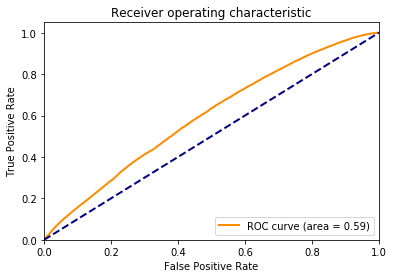

In [135]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()